# Using LR Schedulers

The notebook demonstrates how to configure simple LR schedulers with Hyrax. A list of LR schedulers can be found in the PyTorch documentation here: https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LRScheduler.html.

Hyrax config does not support chained or sequential LR schedulers; those must be directly defined in the model if desired to be used. This notebook will walk through the default LR used in Hyrax as well as defining an ExponentialLR defined in the config.

## The Default Scheduler in Hyrax

When no scheduler is specified in the user-defined config or in the model, Hyrax uses an [ExponentialLR](https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html) scheduler with `gamma = 1`; this means it simply multiplies the starting learning rate by 1 on each epoch, which leads to no practical effect.

We begin by setting up and training a HyraxCNN model with the CIAR10 dataset, like in the [Getting Started](<getting_started.ipynb>) notebook. For more information on this model, see there.

In [ ]:
from hyrax import Hyrax

h = Hyrax()
h.set_config("model.name", "HyraxCNN")

data_request_definition = {
    "train": {
        "data": {
            "dataset_class": "HyraxCifarDataset",
            "data_location": "./data",
            "fields": ["image", "label"],
            "primary_id_field": "object_id",
        },
    },
    "infer": {
        "data": {
            "dataset_class": "HyraxCifarDataset",
            "data_location": "./data",
            "fields": ["image", "object_id"],
            "primary_id_field": "object_id",
            "dataset_config": {
                "use_training_data": False,
            },
        },
    },
}
h.set_config("data_request", data_request_definition)
trained_model = h.train()

## Performance of the model

Assuming everything is working properly, the resulting accuracy on the test set and confusion matrix shouldn't be much different from what is in the [Getting Started](<getting_started.ipynb>) notebook

In [ ]:
inference_results = h.infer()

In [13]:
import numpy as np

predicted_classes = np.argmax(inference_results, axis=1)

In [14]:
import pickle

with open("./data/cifar-10-batches-py/test_batch", "rb") as f_in:
    test_data = pickle.load(f_in, encoding="bytes")


Accuracy for test dataset: 0.4836


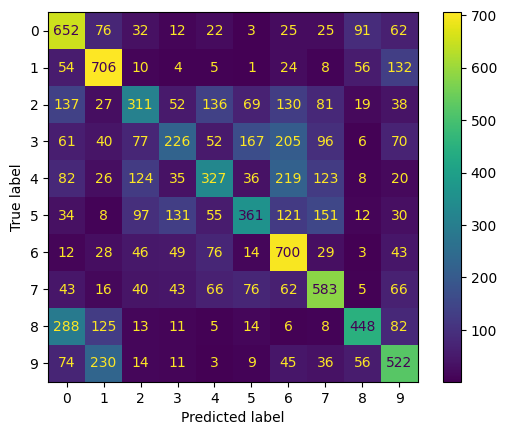

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_true = test_data[b"labels"]
y_pred = predicted_classes.tolist()

correct = 0
for t, p in zip(y_true, y_pred):
    correct += t == p

print("\nAccuracy for test dataset:", correct / len(y_true))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Both the overall accuracy and the confusion matrix resemble what we see in the [Getting Started](<getting_started.ipynb>) notebook.

## Defining a Custom ExponentialLR

Now let's see what happens when we define our own ExponentialLR scheduler. All schedulers accept an `optimizer` as an argument which should match the optimizer actually being used in the model. They also accept an argument called `last_epoch` which enables the scheduler to calculate learning rates properly in the evetn training is being resumed from some midpoint as opposed to beginning from the start. Fortunately, Hyrax takes care of the former for us and checkpointing handles the latter (you probably shouldn't introduce new learning rate schedulers between pausing and resuming training), so only the parameters that directly concern the scheduler are relevant.

For the ExponentialLR, the only parameter aside from `optimizer` and `last_epoch` is `gamma`. This scheduler multiplies the previous epoch's learning rate by `gamma` to determine the new learning rate before beginning each epoch with the base learning rate being used on the very first epoch. We shall adjust our model to use a `gamma` of `0.9`.

In [ ]:
h = Hyrax()
h.set_config("model.name", "HyraxCNN")
h.set_config("data_request", data_request_definition)
h.set_config("scheduler", {"name": "torch.optim.lr_scheduler.ExponentialLR"})
h.set_config("'torch.optim.lr_scheduler.ExponentialLR'", {"gamma": 0.9})

In [ ]:
trained_model = h.train()

In [ ]:
inference_results = h.infer()

In [19]:
predicted_classes = np.argmax(inference_results, axis=1)


Accuracy for test dataset: 0.3818


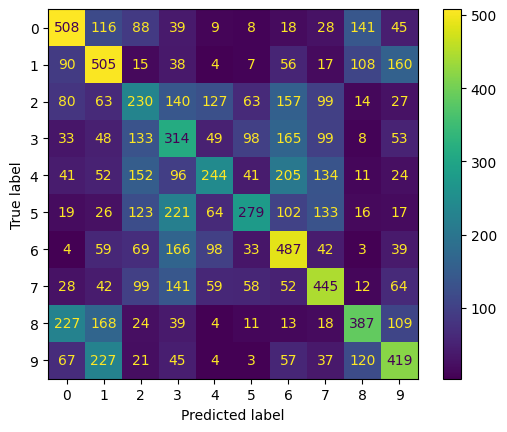

In [20]:
y_true = test_data[b"labels"]
y_pred = predicted_classes.tolist()

correct = 0
for t, p in zip(y_true, y_pred):
    correct += t == p

print("\nAccuracy for test dataset:", correct / len(y_true))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

The results may be a bit worse than without using the learning rate scheduler, but that is to be expected since we didn't really try doing any sort of tuning and just wanted to demonstrate the feature. We can also see the history of the learning rates in the TensorBoard to verify that the scheduler did in fact have an effect:

![tensorboard_lr_history.png](tensorboard_lr_history.png)